In [1]:
from util._io import read_config
from collections import namedtuple
from pathlib import Path
import pandas as pd
import numpy as np

import fastsca

import _pnmf,_dcpnmf,_dcpnmfb,_dcpnmfv2,_dcnpnmf
np.random.seed(42)

import matplotlib.pylab as plt
import seaborn as sns
import colorcet as cc
import _topics_util


experiment = '/projects/experiments/asapp/'
server = Path.home().as_posix()
experiment_home = server+experiment
experiment_config = read_config(experiment_home+'config.yaml')
args = namedtuple('Struct',experiment_config.keys())(*experiment_config.values())

sca = fastsca.FASTSCA()
sca.config = args
fn = sca.config.home + sca.config.experiment +sca.config.output + sca.config.sample_id+'/'+sca.config.sample_id
fn

'/home/BCCRC.CA/ssubedi/projects/experiments/asapp/result/simdata/simdata'

In [2]:
# H,W = sca.simdata(N=1000,K=10,P=2000)
# pd.DataFrame(H).to_csv(fn+'_H.csv.gz',compression='gzip',index=False)
# pd.DataFrame(W).to_csv(fn+'_W.csv.gz',compression='gzip',index=False)
# pd.DataFrame(sca.data.mtx).to_csv(fn+'_X.csv.gz',compression='gzip',index=False)


H = pd.read_csv(fn+'_H.csv.gz')
W = pd.read_csv(fn+'_W.csv.gz')
X = pd.read_csv(fn+'_X.csv.gz')
sca.data.mtx = np.asmatrix(X)

<AxesSubplot:>

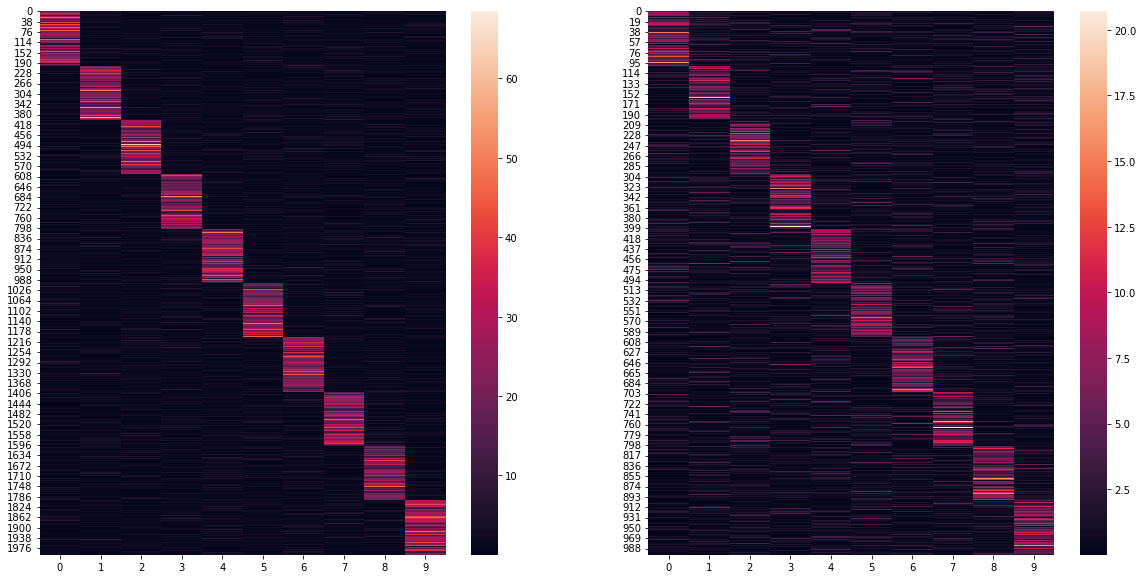

In [3]:
plt.rcParams["figure.figsize"] = (20,10)
figure,axis = plt.subplots(1,2)
sns.heatmap(W,ax=axis[0])
sns.heatmap(H.T,ax=axis[1])


In [4]:
import importlib
importlib.reload(fastsca)
# model = _dcnpnmf.DCNPoissonMF()
# model.fit_null(np.asarray(sca.data.mtx))
fastsca.run_dcasapp(sca,min_leaf=1,max_depth=10,n_components=10,max_iter=100,save=fn)
fastsca.run_scNMF(sca,n_components=10,max_iter=100,save=fn+'_sc')

updating null model....
	After ITERATION: 0	Objective: 401592829.21	Old objective: -inf	Improvement: nan
	After ITERATION: 1	Objective: 401592829.21	Old objective: 401592829.21	Improvement: 0.00000




/home/BCCRC.CA/ssubedi/projects/experiments/asapp/asapp/_dcnpnmf.py:56: RuntimeWarning: invalid value encountered in double_scalars
  improvement = (bound - old_bd) / abs(old_bd)


updating null model....
	After ITERATION: 0	Objective: 633598958.01	Old objective: -inf	Improvement: nan
	After ITERATION: 1	Objective: 633598958.01	Old objective: 633598958.01	Improvement: 0.00000


updating full model....
updating full model....0
updating full model....1


/home/BCCRC.CA/ssubedi/projects/experiments/asapp/asapp/_dcpnmf.py:76: RuntimeWarning: invalid value encountered in double_scalars
  improvement = (bound - old_bd) / abs(old_bd)


updating full model....2
updating full model....3
updating full model....4
updating full model....5
updating full model....6
updating full model....7
updating full model....8
updating full model....9
updating full model....10
updating full model....11
updating full model....12
updating full model....13
updating full model....14
updating full model....15
updating full model....16
updating full model....17
updating full model....18
updating full model....19
updating full model....20
updating full model....21
updating full model....22
updating full model....23
updating full model....24
updating full model....25
updating full model....26
updating full model....27
updating full model....28
updating full model....29
updating full model....30
updating full model....31
updating full model....32
updating full model....33
updating full model....34
updating full model....35
updating full model....36
updating full model....37
updating full model....38
updating full model....39
updating full model.

/home/BCCRC.CA/ssubedi/projects/experiments/asapp/asapp/_dcpnmf.py:76: RuntimeWarning: invalid value encountered in double_scalars
  improvement = (bound - old_bd) / abs(old_bd)


	After ITERATION: 0	Objective: 401592829.21	Old objective: -inf	Improvement: nan
	After ITERATION: 1	Objective: 401592829.21	Old objective: 401592829.21	Improvement: 0.00000


updating full model....
updating full model....0
updating full model....1
updating full model....2
updating full model....3
updating full model....4
updating full model....5
updating full model....6
updating full model....7
updating full model....8
updating full model....9
updating full model....10
updating full model....11
updating full model....12
updating full model....13
updating full model....14
updating full model....15
updating full model....16
updating full model....17
updating full model....18
updating full model....19
updating full model....20
updating full model....21
updating full model....22
updating full model....23
updating full model....24
updating full model....25
updating full model....26
updating full model....27
updating full model....28
updating full model....29
updating full model....30
upda

In [5]:
df_bd = pd.read_csv(fn+'_depth.csv.gz')
df_bf = pd.read_csv(fn+'_freq.csv.gz')
df_bbeta = pd.read_csv(fn+'_beta.csv.gz')
df_btheta = pd.read_csv(fn+'_theta.csv.gz')

df_scd = pd.read_csv(fn+'_sc_depth.csv.gz')
df_scf = pd.read_csv(fn+'_sc_freq.csv.gz')
df_scbeta = pd.read_csv(fn+'_sc_beta.csv.gz')
df_sctheta = pd.read_csv(fn+'_sc_theta.csv.gz')
df_btheta = df_btheta.rename(columns={'Unnamed: 0':'cell'})
df_bbeta = df_bbeta.rename(columns={'Unnamed: 0':'topic'})
df_sctheta = df_sctheta.rename(columns={'Unnamed: 0':'cell'})
df_scbeta = df_scbeta.rename(columns={'Unnamed: 0':'topic'})

df_bulk_b = pd.read_csv(fn+'_bulk_trace.csv.gz')
df_sc_b = pd.read_csv(fn+'_sc_bulk_trace.csv.gz')
df_scbulk_b = pd.read_csv(fn+'_sc_trace.csv.gz')


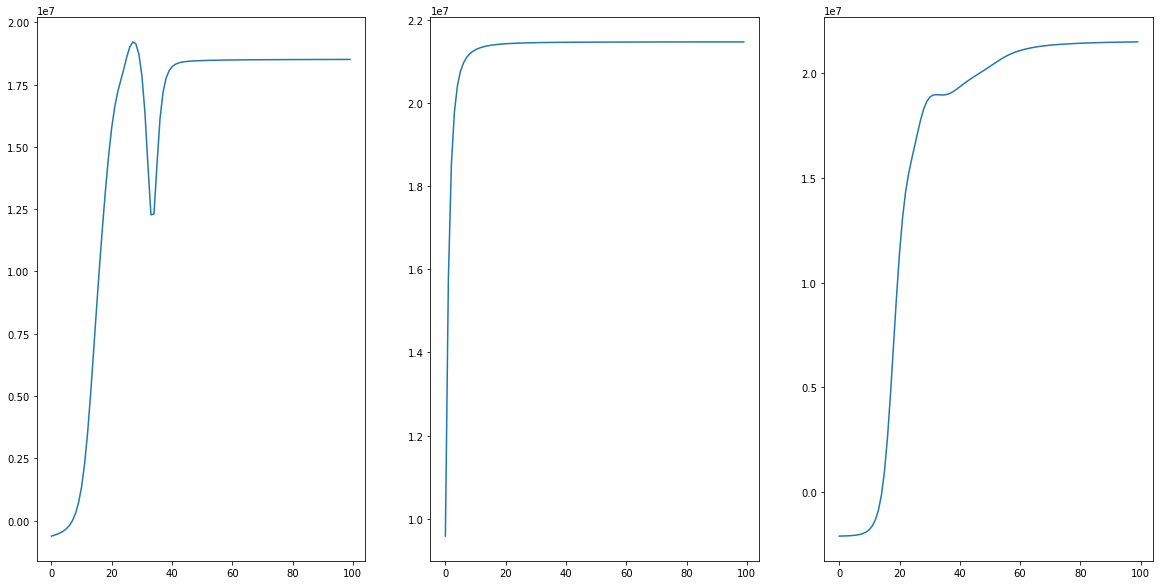

In [6]:
figure,axis = plt.subplots(1,3)
axis[0].plot(df_bulk_b.iloc[:,1].values)
axis[1].plot(df_scbulk_b.iloc[:,1].values)
axis[2].plot(df_sc_b.iloc[:,1].values)

In [7]:
import umap

df_umap= pd.DataFrame()
df_umap['cell'] = df_sctheta['cell']
df_umap['topic_sc'] = [x for x in df_sctheta.iloc[:,1:].idxmax(axis=1)]
df_umap['topic_bulk'] = [x for x in df_btheta.iloc[:,1:].idxmax(axis=1)]

umap_2d = umap.UMAP(n_components=2, init='random', random_state=0,min_dist=0.0,metric='cosine')
proj_2d = umap_2d.fit(df_sctheta.iloc[:,1:])
df_umap[['umap1','umap2']] = umap_2d.embedding_[:,[0,1]]
df_umap

,cell,topic_sc,topic_bulk,umap1,umap2
0,0,4,2,3.722245,2.916182
1,1,4,2,4.282474,3.703205
2,2,4,2,3.650725,2.656061
3,3,4,2,3.876111,4.594874
4,4,4,2,3.470914,2.584887
...,...,...,...,...,...
995,995,0,6,2.597773,-3.695280
996,996,2,7,7.564920,0.007683
997,997,8,6,4.818621,6.360630
998,998,0,6,2.949039,-3.541884


Text(0, 0.5, 'UMAP2')

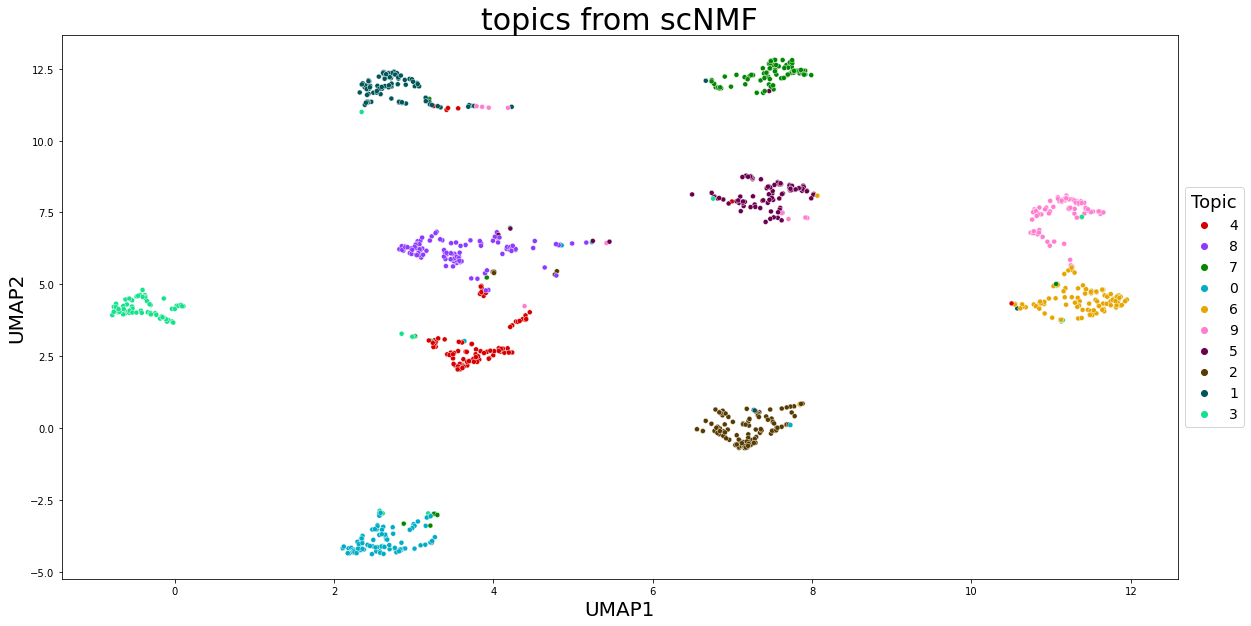

In [8]:
cp = sns.color_palette(cc.glasbey_dark, n_colors=len(df_umap['topic_sc'].unique()))
p = sns.scatterplot(data=df_umap, x='umap1', y='umap2', hue='topic_sc',s=25,palette=cp,legend=True)
plt.legend(title='Topic',title_fontsize=18, fontsize=14,loc='center left', bbox_to_anchor=(1, 0.5))
p.axes.set_title("topics from scNMF",fontsize=30)
p.set_xlabel("UMAP1",fontsize=20)
p.set_ylabel("UMAP2",fontsize=20)

Text(0, 0.5, 'UMAP2')

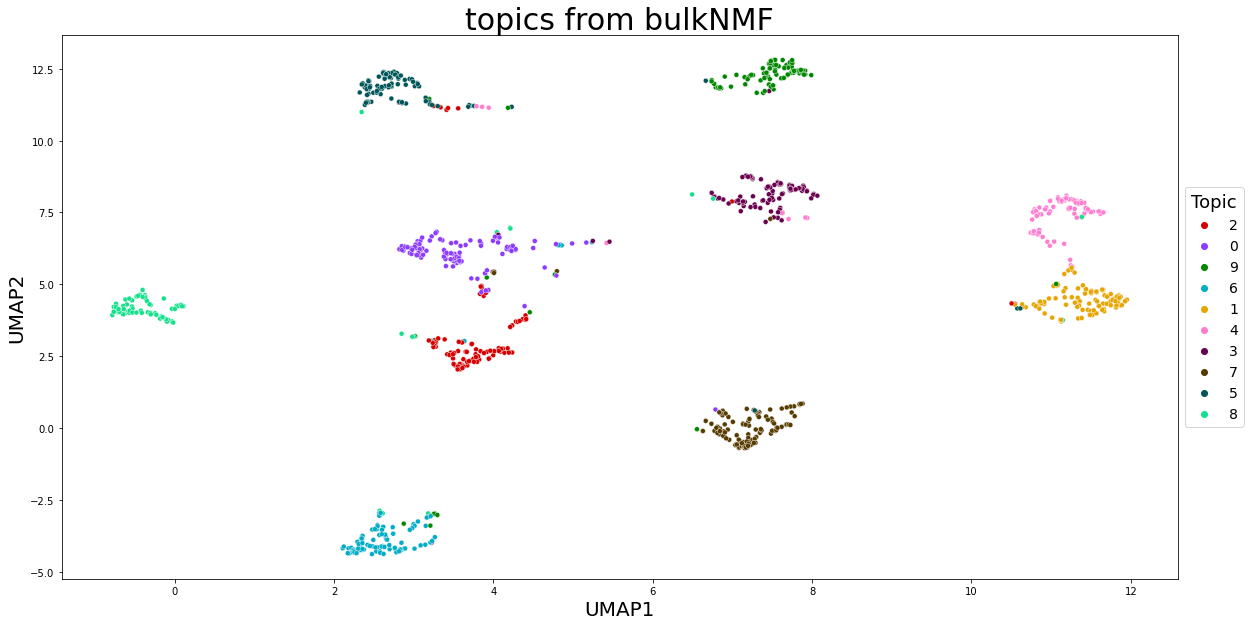

In [9]:
cp = sns.color_palette(cc.glasbey_dark, n_colors=len(df_umap['topic_bulk'].unique()))
p = sns.scatterplot(data=df_umap, x='umap1', y='umap2', hue='topic_bulk',s=25,palette=cp,legend=True)
plt.legend(title='Topic',title_fontsize=18, fontsize=14,loc='center left', bbox_to_anchor=(1, 0.5))
p.axes.set_title("topics from bulkNMF",fontsize=30)
p.set_xlabel("UMAP1",fontsize=20)
p.set_ylabel("UMAP2",fontsize=20)

Text(159.0, 0.5, 'bulk')

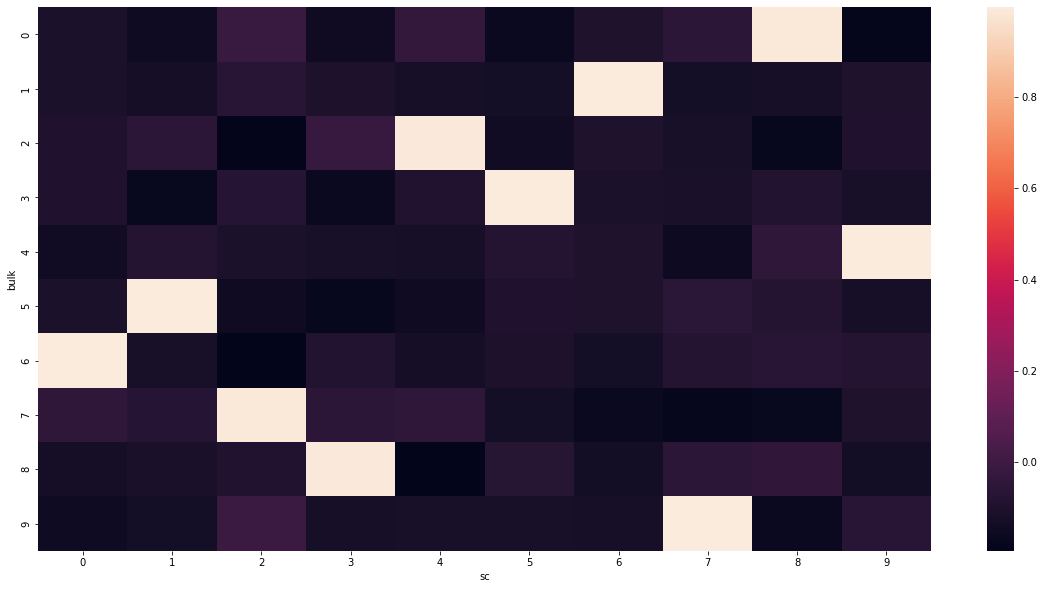

In [24]:
sel_top_genes = list(np.unique(_topics_util.get_topic_top_genes(df_scbeta.iloc[:,1:],top_n=10)['Gene'].values))
K=10
corr=[]
for i in range(K):
    cr = []
    for j in range(K):
        cr.append(np.corrcoef(df_bbeta.loc[i,sel_top_genes],df_scbeta.loc[j,sel_top_genes])[0,1])
    corr.append(cr)
sns.heatmap(corr)
plt.xlabel('sc')
plt.ylabel('bulk')



Text(159.0, 0.5, 'bulk')

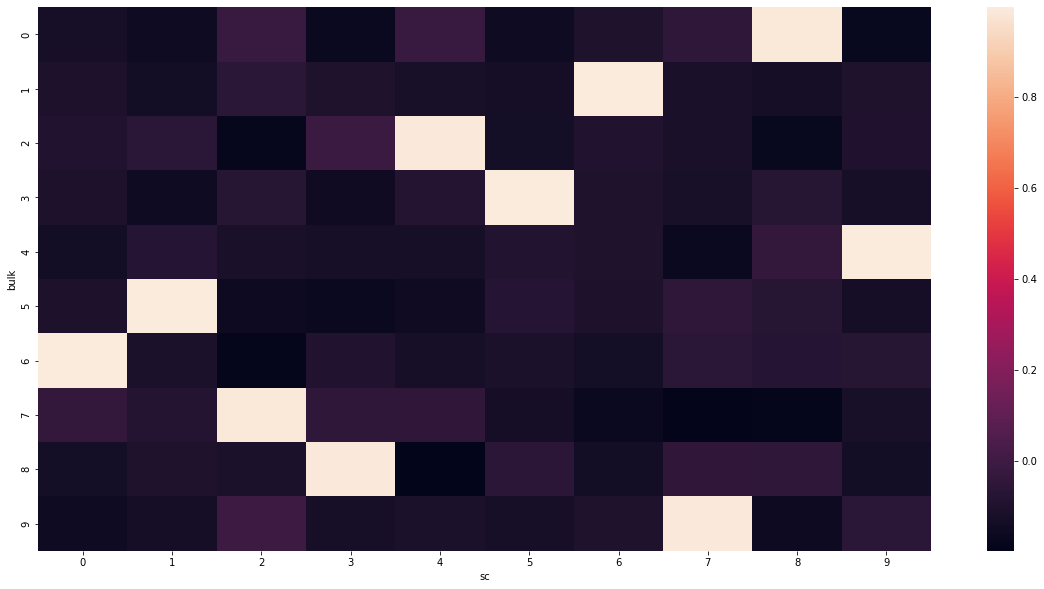

In [22]:
corr=[]
for i in range(K):
    cr = []
    for j in range(K):
        cr.append(np.corrcoef(df_bbeta.iloc[i,1:],df_scbeta.iloc[j,1:])[0,1])
    corr.append(cr)
sns.heatmap(corr)
plt.xlabel('sc')
plt.ylabel('bulk')

In [ ]:
df_top = _topics_util.get_topic_top_genes(df_scbeta.iloc[:,1:],top_n=10)
df_top[df_top['Topic']=='k7'].sort_values('Proportion',ascending=False).head(10)


In [ ]:
df_top = _topics_util.get_topic_top_genes(df_bbeta.iloc[:,1:],top_n=10)
df_top[df_top['Topic']=='k9'].sort_values('Proportion',ascending=False).head(10)

In [ ]:
df_bf.sort_values('freq',ascending=False)

/home/BCCRC.CA/ssubedi/.conda/envs/ssubedi/lib/python3.9/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


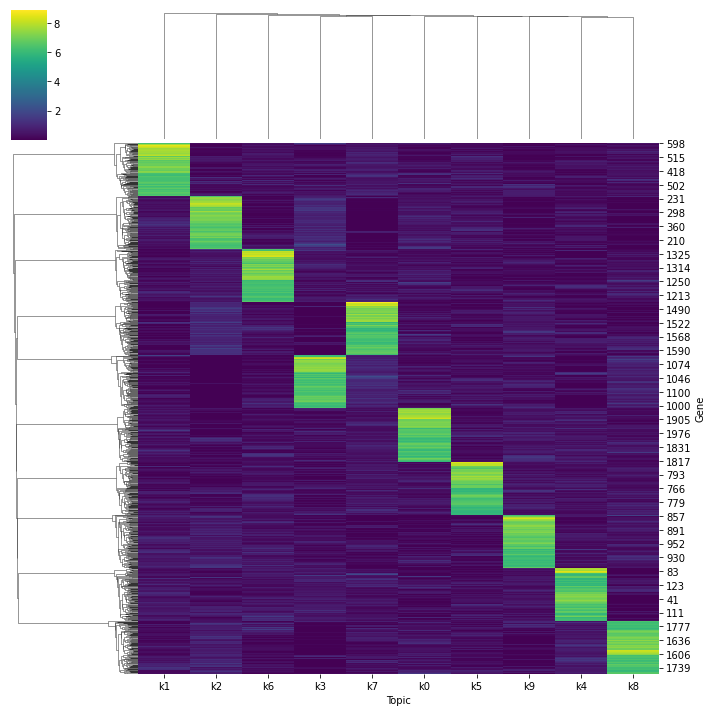

In [20]:
df_top = _topics_util.get_topic_top_genes(df_scbeta.iloc[:,1:],top_n=100)
df_top = df_top.pivot(index='Topic',columns='Gene',values='Proportion')
sns.clustermap(df_top.T,cmap='viridis')

Text(159.0, 0.5, 'bulk')

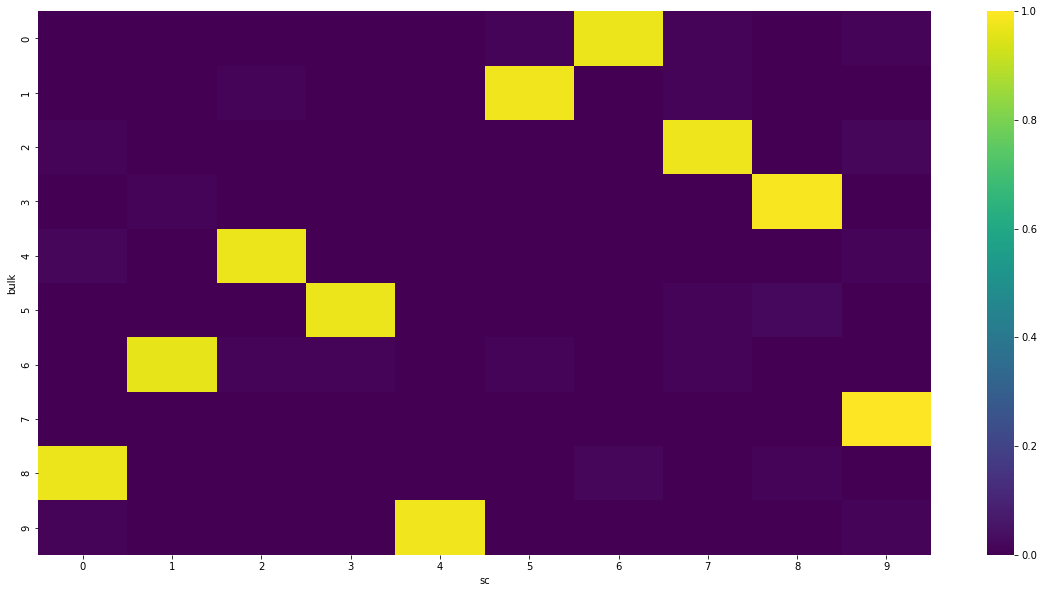

In [26]:

from sklearn.metrics.cluster import contingency_matrix
df_rmatch = pd.DataFrame(contingency_matrix(df_umap.topic_sc,df_umap.topic_bulk))
df_rmatch = df_rmatch.div(df_rmatch.sum(axis=1), axis=0)
sns.heatmap(df_rmatch,cmap='viridis')
plt.xlabel('sc')
plt.ylabel('bulk')
